#                Face mask detector using RetinaNet

## Step 1. Convert the xml annotations to CSV

In [1]:
import os
print(os.getcwd())

/home/hongbing/Projects/MachineLearning-ComputerVision-DataScience/object_detection/RetinaNet/face_mask_detector


In [2]:
 os.chdir('./dataset')
 !python ~/Projects/tools/xml-to-csv.py --image_dir maskDetectorJPEGImages --annotation_dir maskDetectorXMLfiles mask_detector_annotations.csv
 os.chdir('../')

processing maskDetectorXMLfiles/571.xml
processing maskDetectorXMLfiles/465.xml
processing maskDetectorXMLfiles/394.xml
processing maskDetectorXMLfiles/61.xml
processing maskDetectorXMLfiles/161.xml
processing maskDetectorXMLfiles/615.xml
processing maskDetectorXMLfiles/626.xml
processing maskDetectorXMLfiles/46.xml
processing maskDetectorXMLfiles/13.xml
processing maskDetectorXMLfiles/59.xml
processing maskDetectorXMLfiles/198.xml
processing maskDetectorXMLfiles/656.xml
processing maskDetectorXMLfiles/673.xml
processing maskDetectorXMLfiles/679.xml
processing maskDetectorXMLfiles/590.xml
processing maskDetectorXMLfiles/145.xml
processing maskDetectorXMLfiles/546.xml
processing maskDetectorXMLfiles/382.xml
processing maskDetectorXMLfiles/358.xml
processing maskDetectorXMLfiles/258.xml
processing maskDetectorXMLfiles/665.xml
processing maskDetectorXMLfiles/334.xml
processing maskDetectorXMLfiles/271.xml
processing maskDetectorXMLfiles/176.xml
processing maskDetectorXMLfiles/425.xml
proc

## Step 2. Load the annotations

In [3]:
import pandas as pd

df = pd.read_csv('dataset/mask_detector_annotations.csv')

# Adding column name to the DataFrame : We can add columns to an existing DataFrame using its columns attribute.

df.columns = ['fileName','xmin','ymin','xmax','ymax','class']

df.shape

(822, 6)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras_retinanet.utils.visualization import draw_box, draw_caption , label_color
from keras_retinanet.utils.image import preprocess_image, resize_image

## Step 3. Write a function to show bounding boxes on training dataset

[153, 443, 614, 935]


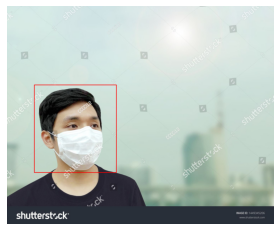

In [5]:
def show_image_with_boxes(df):
  # pick a random image
  filepath = df.sample()['fileName'].values[0]

  # get all rows for this image
  df2 = df[df['fileName'] == filepath]
  im = np.array(Image.open('dataset/' + filepath))

  # if there's a PNG it will have alpha channel
  im = im[:,:,:3]

  for idx, row in df2.iterrows():
    box = [
      row['xmin'],
      row['ymin'],
      row['xmax'],
      row['ymax'],
    ]
    print(box)
    draw_box(im, box, color=(255, 0, 0))

  plt.axis('off')
  plt.imshow(im)
  plt.show()                  
                  
                  
show_image_with_boxes(df)                  
      


In [6]:
#Check few records of data
df.head()

fileName  xmin  ymin  xmax  ymax   class
0  maskDetectorJPEGImages/465.jpg   229    38   621   503    mask
1  maskDetectorJPEGImages/394.jpg   249    28   693   514    mask
2   maskDetectorJPEGImages/61.jpg   195    12   335   167  noMask
3  maskDetectorJPEGImages/161.jpg   397    69  1092   960  noMask
4  maskDetectorJPEGImages/615.jpg   104     9   209   141    mask

In [7]:
#Define labels & write them in a file
classes = ['mask','noMask']
with open('dataset/mask_detector_classes.csv', 'w') as f:
  for i, class_name in enumerate(classes):
    f.write(f'{class_name},{i}\n')
            
if not os.path.exists('snapshots'):
  os.mkdir('snapshots')                  

## Step 4. Train RetinaNet Model

It's better to start with pretrained model in lieu of training a model from scratch. We'll use ResNet50 model that's already pretrained on Coco dataset.

large batch size will cause out of memory issue, for example batch-size=4.

In [8]:
#Put your training data path & file that has labels for your training data

!python ~/Projects/keras-retinanet/keras_retinanet/bin/train.py \
    --weights=/home/hongbing/Projects/keras-retinanet/resnet50_coco_v2.1.0/resnet50_coco_best_v2.1.0.h5 \
    --pyramid-feature-size=256 \
    --classification-feature-size=256 \
    --regression-feature-size=256 \
    --snapshot-path snapshots \
    --random-transform \
    --epochs=15 \
    --steps=500 \
    csv dataset/mask_detector_annotations.csv dataset/mask_detector_classes.csv

Using TensorFlow backend.


2021-05-18 23:35:14.019234: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-05-18 23:35:14.040522: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2799925000 Hz
2021-05-18 23:35:14.040922: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x58718d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-05-18 23:35:14.040953: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-05-18 23:35:14.042261: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-05-18 23:35:14.102240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-

### Let’s analyze each argument passed to the script train.py.

####           1.freeze-backbone: freeze the backbone layers, particularly useful when we use a small dataset, to avoid overfitting
####       2.random-transform: randomly transform the dataset to get data augmentation
####       3.weights: initialize the model with a pretrained model (your own model or one released by Fizyr)
####       4.batch-size: training batch size, higher value gives smoother learning curve
####       5.steps: number of steps for epochs
####       6.epochs: number of epochs to train
####       7.csv: annotations files generated by the script above

## Step 5. Load Trained Model

In [9]:
from glob import glob
model_paths = glob('snapshots/resnet50_csv_*.h5')
latest_path = sorted(model_paths)[-1]
print("path:", latest_path)


path: snapshots/resnet50_csv_15.h5


In [10]:
from keras_retinanet import models

model = models.load_model(latest_path, backbone_name='resnet50')
model = models.convert_model(model)

label_map = {}
for line in open('dataset/mask_detector_classes.csv'):
  row = line.rstrip().split(',')
  label_map[int(row[1])] = row[0]

Using TensorFlow backend.














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





In [11]:
label_map

{0: 'mask', 1: 'noMask'}

## Step 6. Predict using trained model

In [36]:
def predict_image(df, filepath, threshold=0.6):
  # get all rows for this image
  df2 = df[df['fileName'] == filepath]
  im = np.array(Image.open('dataset/' + filepath))
  print("im.shape:", im.shape)

  # if there's a PNG it will have alpha channel
  im = im[:,:,:3]

  # plot true boxes
  for idx, row in df2.iterrows():
    box = [
      row['xmin'],
      row['ymin'],
      row['xmax'],
      row['ymax'],
    ]
    print(box)
    draw_box(im, box, color=(255, 0, 0))
  
  ### plot predictions ###

  # get predictions
  imp = preprocess_image(im)
  imp, scale = resize_image(im)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(imp, axis=0)
  )

  # standardize box coordinates
  boxes /= scale

  # loop through each prediction for the input image
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can quit as soon
    # as we see a score below threshold
    if score < threshold:
      break

    box = box.astype(np.int32)
    color = label_color(label)
    draw_box(im, box, color=color)

    class_name = label_map[label]
    caption = f"{class_name} {score:.3f}"
    draw_caption(im, box, caption)
    score, label=score, label

    print("{}, {}, {}".format(box, score, label))
  plt.axis('off')
  plt.imshow(im)
  plt.show()
  return score, label
plt.rcParams['figure.figsize'] = [20, 10]

In [32]:
#Write a function to choose one image randomly from your dataset and predict using Trained model.
def show_image_with_predictions(df, threshold=0.6):
  # choose a random image
  row = df.sample()
  filepath = row['fileName'].values[0]
  print("filepath:", filepath)

  predict_image(df, filepath, threshold)

filepath: maskDetectorJPEGImages/33.jpg
im.shape: (861, 750, 3)
[369, 137, 580, 403]
[204, 202, 363, 442]


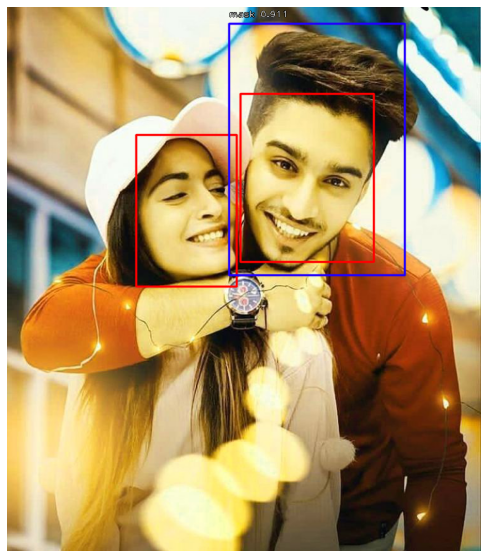

In [17]:
#Feel free to change it as per your business requirement
score, label=show_image_with_predictions(df, threshold=0.6)

im.shape: (861, 750, 3)
[369, 137, 580, 403]
[204, 202, 363, 442]
[351  26 629 424], 0.910659670829773, 0
[188 199 370 439], 0.4564705789089203, 0


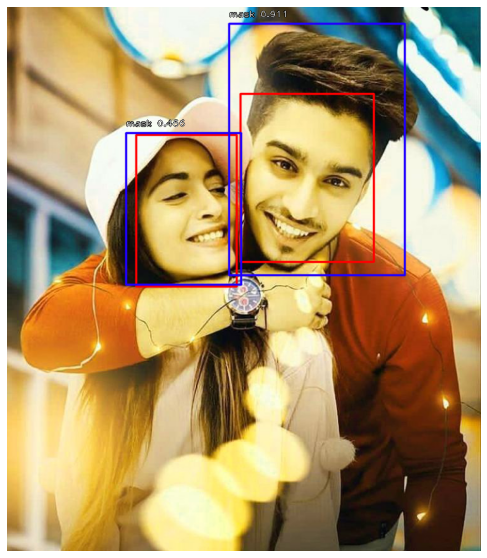

(0.3273785, 1)

In [37]:
predict_image(df, 'maskDetectorJPEGImages/33.jpg', threshold=0.4)

filepath: maskDetectorJPEGImages/277.jpg
im.shape: (168, 300, 3)
[101, 6, 208, 125]


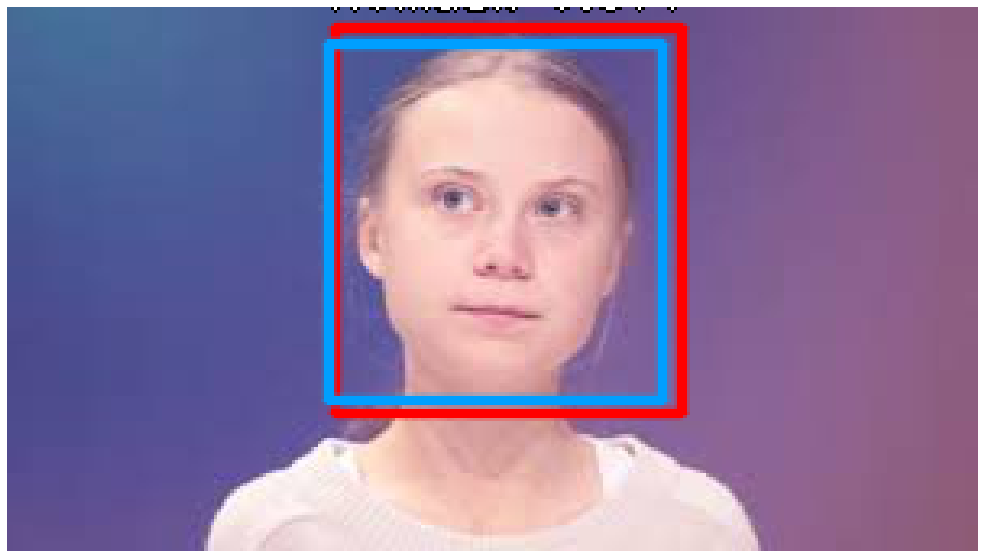

In [18]:
#Feel free to change it as per your business requirement
score, label=show_image_with_predictions(df, threshold=0.6)

filepath: maskDetectorJPEGImages/242.jpg
im.shape: (340, 510, 3)
[259, 3, 389, 162]
[373, 69, 506, 244]


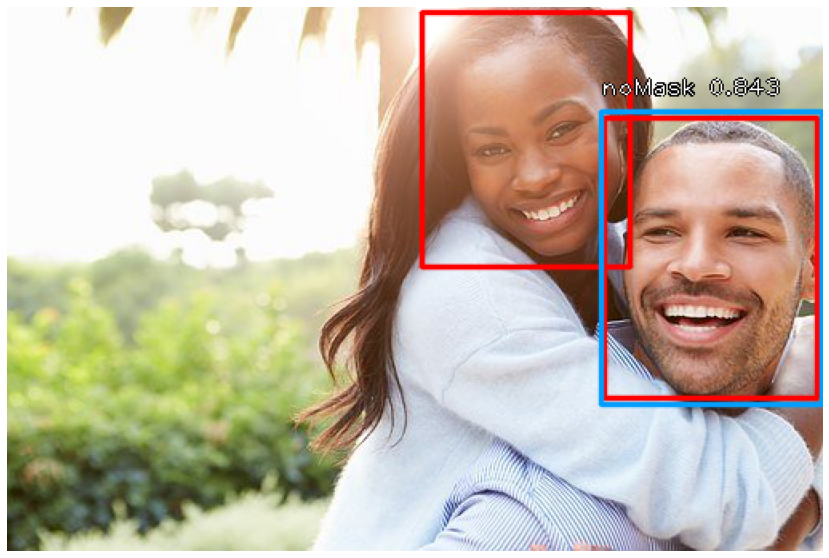

In [20]:
#Feel free to change it as per your business requirement
score, label=show_image_with_predictions(df, threshold=0.6)

filepath: maskDetectorJPEGImages/271.jpg
im.shape: (800, 1520, 3)
[1070, 6, 1216, 159]
[1075, 446, 1252, 629]
[309, 458, 490, 627]
[288, 10, 433, 152]


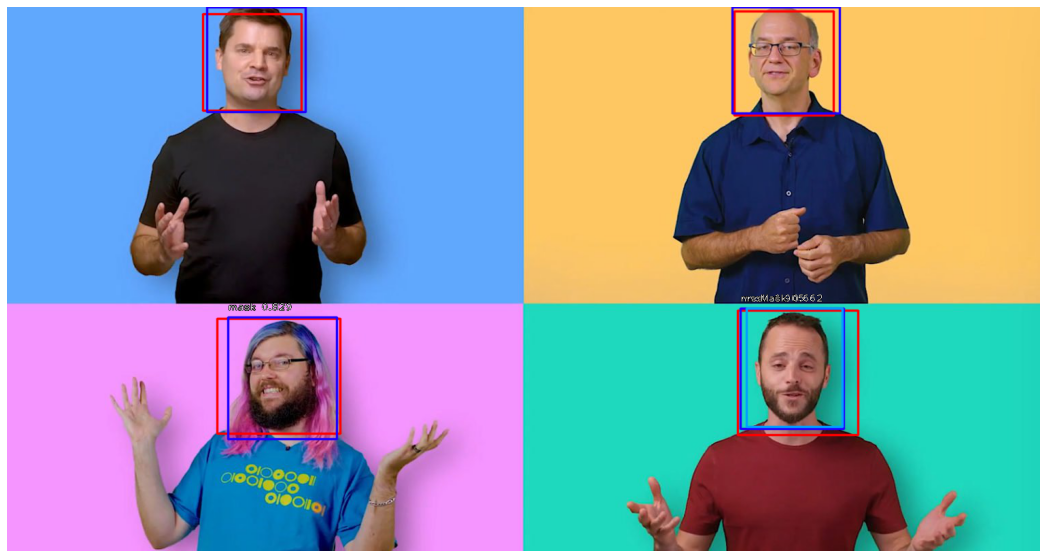

In [22]:
#Feel free to change it as per your business requirement
score, label=show_image_with_predictions(df, threshold=0.6)

filepath: maskDetectorJPEGImages/324.jpg
im.shape: (168, 300, 3)
[108, 4, 197, 109]


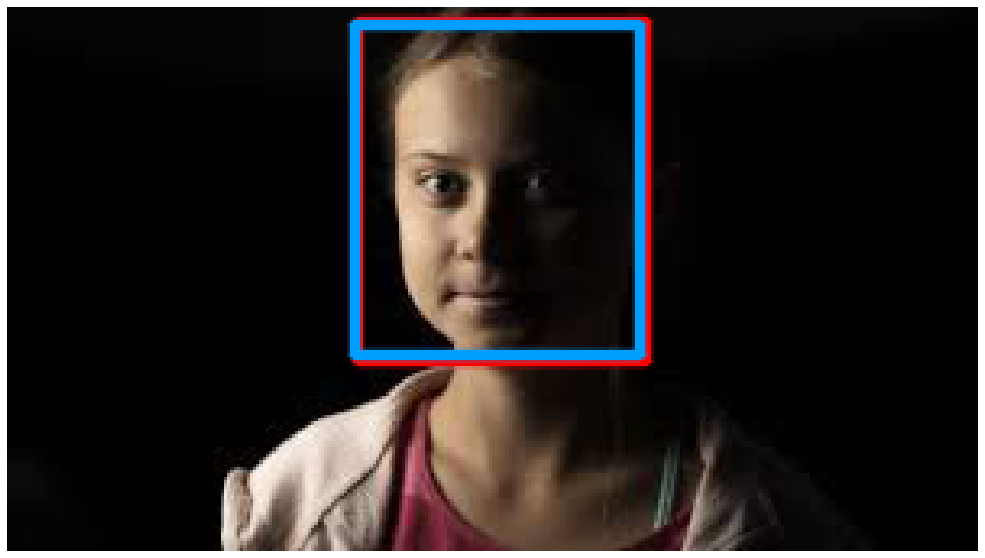

In [23]:
#Feel free to change it as per your business requirement
score, label=show_image_with_predictions(df, threshold=0.6)

filepath: maskDetectorJPEGImages/177.jpg
im.shape: (1080, 1920, 3)
[1073, 16, 1850, 1021]


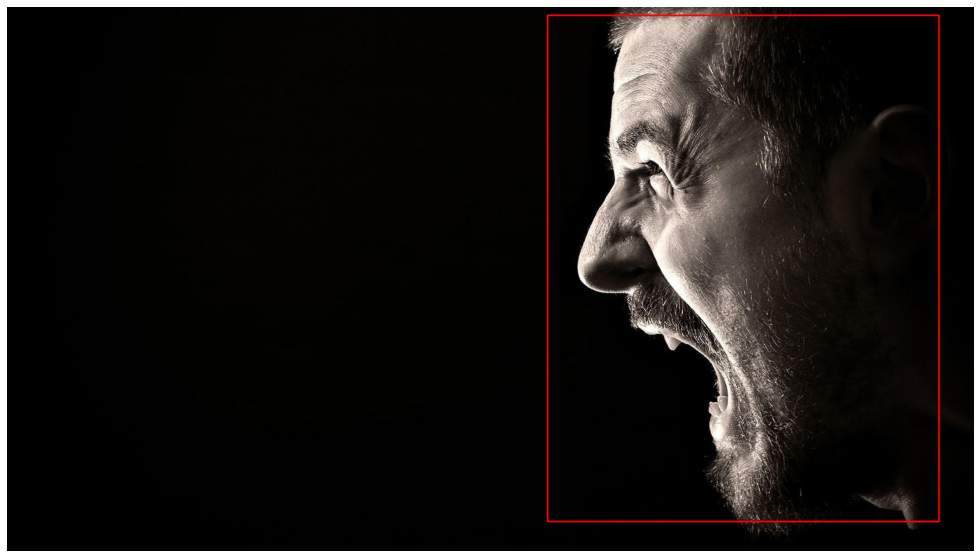

In [24]:
#Feel free to change it as per your business requirement
score, label=show_image_with_predictions(df, threshold=0.6)

filepath: C:/Users/PraveenKumar/RetinaNet/maskDetectorJPEGImages/480.jpg
im.shape: (176, 286, 3)
['80', '1', '132', '62']
['146', '19', '205', '94']


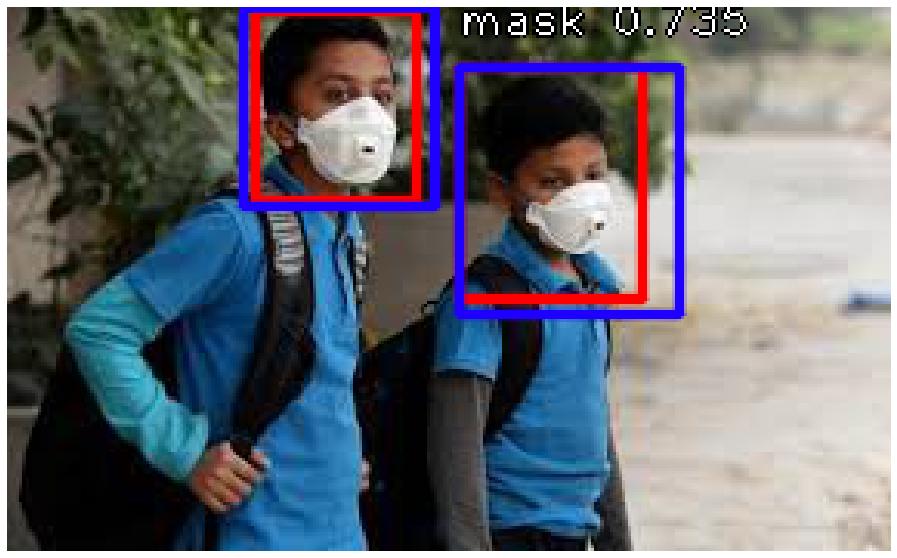

In [90]:
#Feel free to change it as per your business requirement
score, label=show_image_with_predictions(data, threshold=0.6)

filepath: maskDetectorJPEGImages/62.jpg
im.shape: (1500, 1000, 3)
[469, 124, 766, 467]


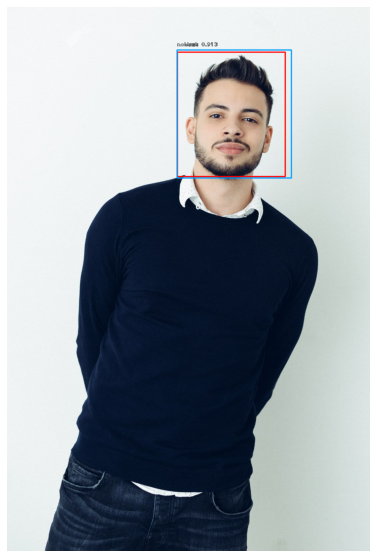

In [25]:
#Feel free to change it as per your business requirement
score, label=show_image_with_predictions(df, threshold=0.6)

filepath: maskDetectorJPEGImages/375.jpg
im.shape: (603, 1200, 3)
[386, 20, 792, 544]


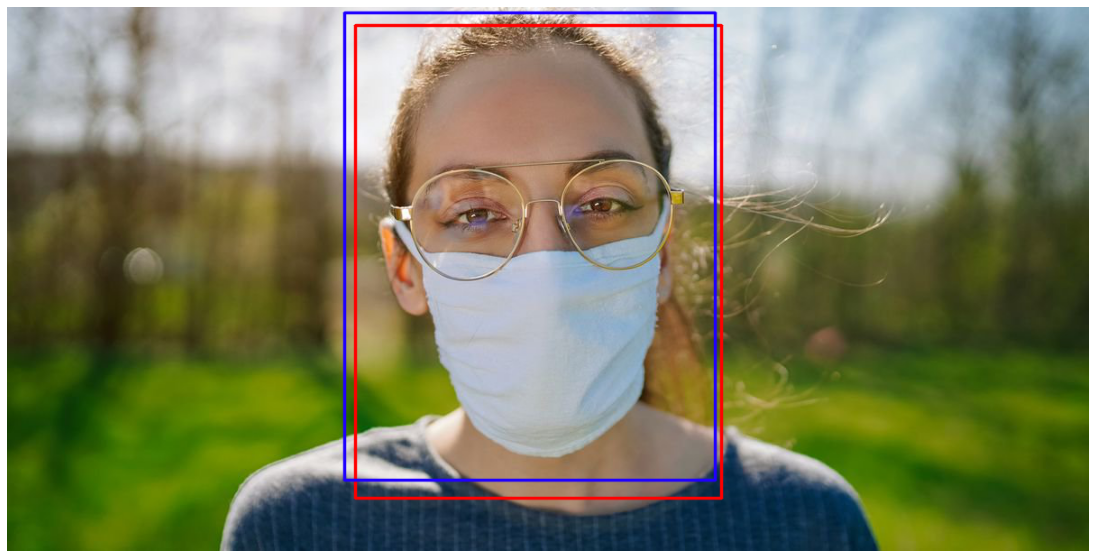

In [26]:
#Feel free to change it as per your business requirement
score, label=show_image_with_predictions(df, threshold=0.6)

filepath: maskDetectorJPEGImages/496.jpg
im.shape: (866, 1300, 3)
[603, 44, 1187, 681]


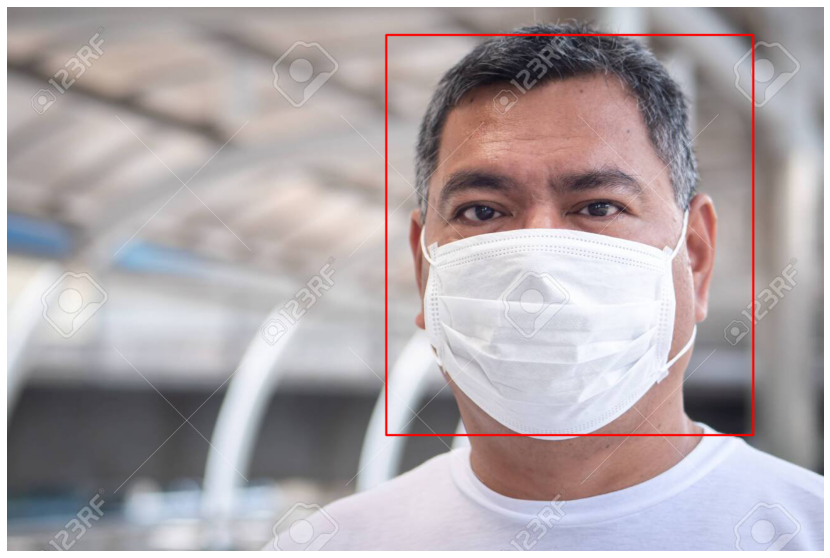

In [27]:
#We've set threshold to 0.6.
#Feel free to change it as per your business requirement
score, label=show_image_with_predictions(df, threshold=0.6)

### Note :- 
###    1. In the image above blue bouding box shows the label prediction whereas red bouding box shows the ground truth bounding box
###    2. You can change the threshold value to your desired value and tune the model.